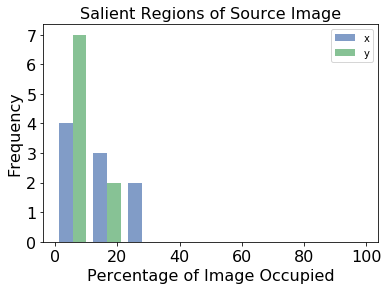

In [60]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# Parameters
numberOfSalientRegions = 14
xMin = 0
xMax = 100
binSize = 10 # Percentage of total image

# Generate some data
mu, sigma = 0, 10 # mean and standard deviation
x = np.random.normal(mu, sigma, numberOfSalientRegions)
y = np.random.normal(mu, sigma, numberOfSalientRegions)

# Stack the arrays in a vertical sequence
data = np.vstack([x, y]).T

# Generate histogram buckets
bins = np.linspace(xMin, xMax, binSize)

# Label the axes and create ticks
plt.title('Salient Regions of Source Image',fontsize=16)
plt.xlabel('Percentage of Image Occupied', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 

plt.hist(data, bins, alpha=0.7, label=['x', 'y'])
plt.legend(loc='upper right')
plt.show()

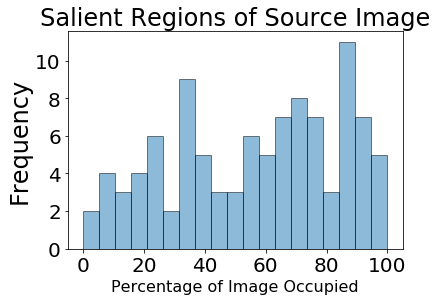

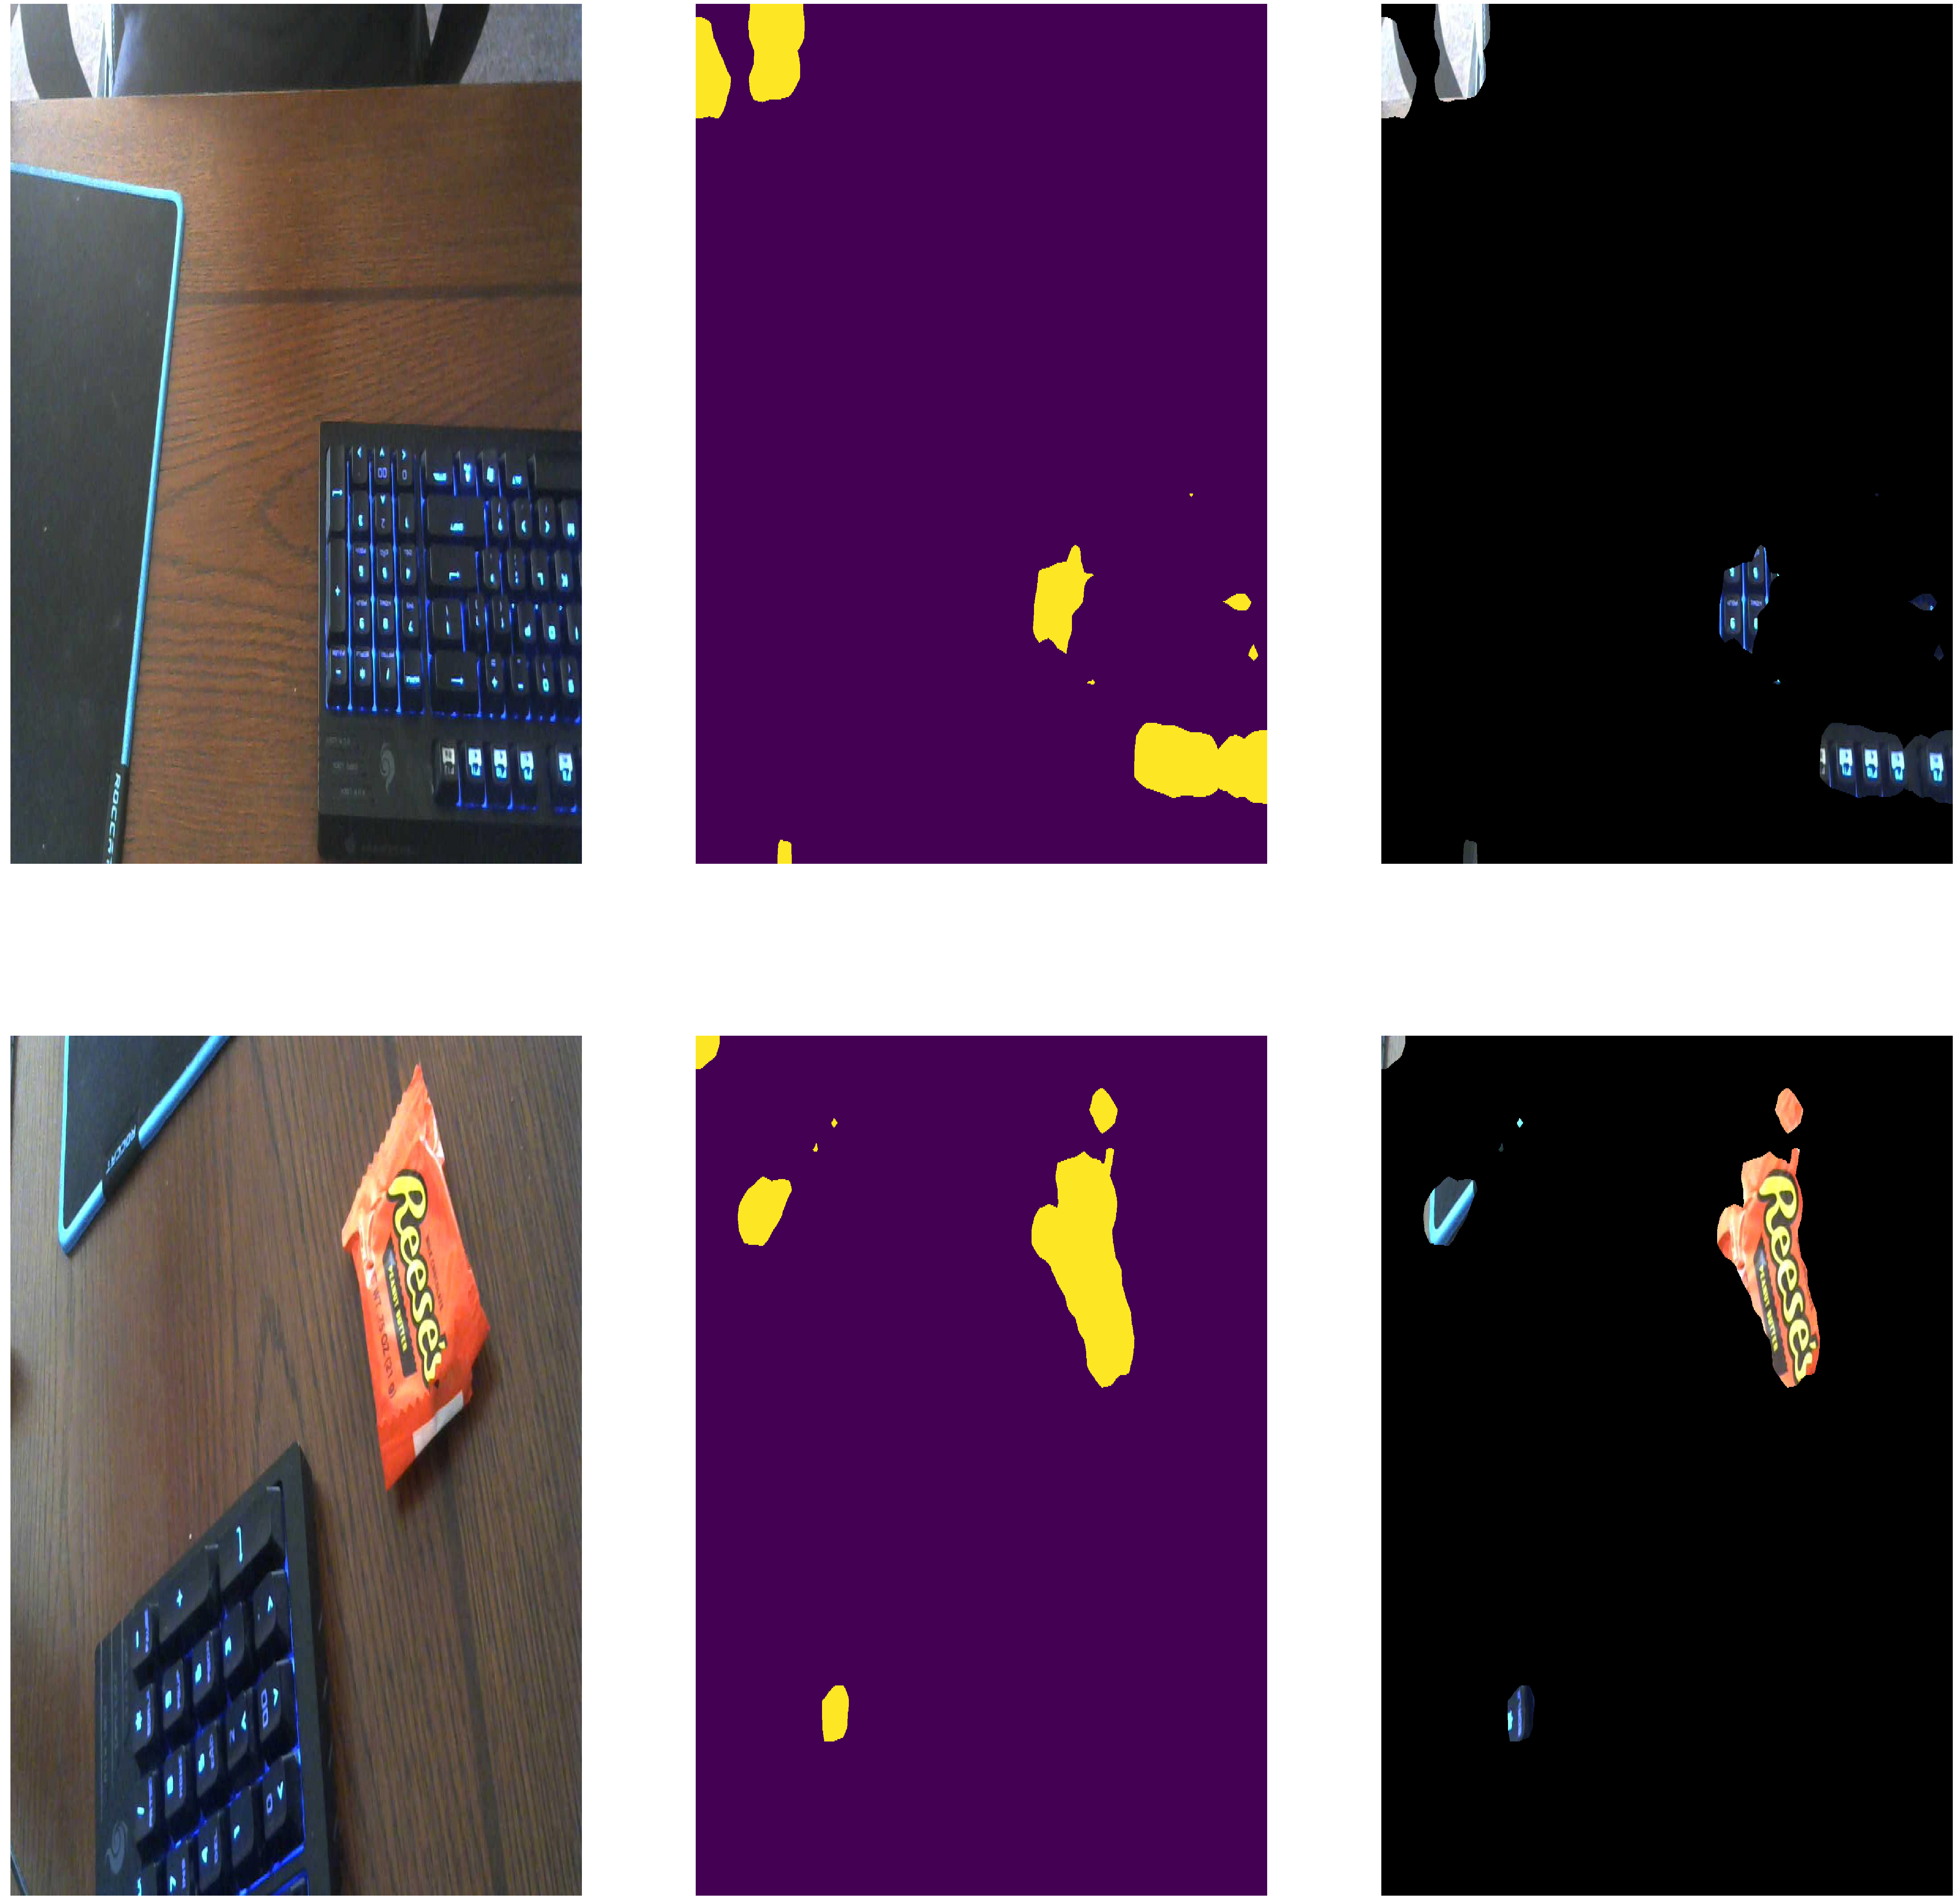

In [32]:
'''
Detecting and Displaying Image Salience with a Binary Threshold
'''

%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('images/scene.jpg', -1)
img2 = cv2.imread('images/scene_with_candy_2.jpg', -1)

### Detect Salience
saliencyDetector = cv2.saliency.StaticSaliencySpectralResidual_create()

success, img1SalienceMap = saliencyDetector.computeSaliency(img1, None)
success, img2SalienceMap = saliencyDetector.computeSaliency(img2, None)

threshold = 0.3

# Apply a binary threshold
img1SalienceMap[img1SalienceMap < threshold] = 0
img1SalienceMap[img1SalienceMap > threshold] = 1
img2SalienceMap[img2SalienceMap < threshold] = 0
img2SalienceMap[img2SalienceMap > threshold] = 1

# Convert from float32 to uint8
img1SalienceMapMask = img1SalienceMap.astype(np.uint8)
img2SalienceMapMask = img2SalienceMap.astype(np.uint8)

# Apply the mask and display the result
img1Masked = cv2.bitwise_and(img1, img1, mask = img1SalienceMapMask)
img2Masked = cv2.bitwise_and(img2, img2, mask = img2SalienceMapMask)
###

# Create subplots to show images
f, axarr = plt.subplots(2,3,figsize=(100,100))

# Convert colors from
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1Masked = cv2.cvtColor(img1Masked, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2Masked = cv2.cvtColor(img2Masked, cv2.COLOR_BGR2RGB)

# Hide axes
axarr[0,0].axis('off')
axarr[0,1].axis('off')
axarr[0,2].axis('off')
axarr[1,0].axis('off')
axarr[1,1].axis('off')
axarr[1,2].axis('off')

# Display images in plot
axarr[0,0].imshow(img1, interpolation='nearest', extent=[0,400,0,1], aspect='auto')
axarr[0,1].imshow(img1SalienceMap, interpolation='nearest', extent=[0,400,0,1], aspect='auto')
axarr[0,2].imshow(img1Masked, interpolation='nearest', extent=[0,400,0,1], aspect='auto')
axarr[1,0].imshow(img2, interpolation='nearest', extent=[0,400,0,1], aspect='auto')
axarr[1,1].imshow(img2SalienceMap, interpolation='nearest', extent=[0,400,0,1], aspect='auto')
axarr[1,2].imshow(img2Masked, interpolation='nearest', extent=[0,400,0,1], aspect='auto')

plt.show()

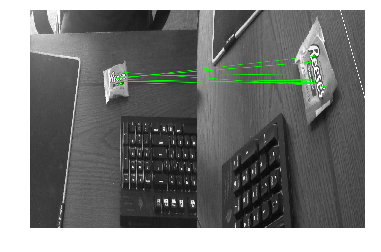

In [2]:
'''
Feature Matching using ORB Feature Detector and Binary Descriptor

ORB feature detection using an oriented FAST detection method and rotated BRIEF descriptors.
'''

%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Load the images in gray scale
img1 = cv2.imread('images/scene_with_candy.jpg', 0)
img2 = cv2.imread('images/scene_with_candy_2.jpg', 0)

### Detect Salience
saliencyDetector = cv2.saliency.StaticSaliencySpectralResidual_create()

success, img1SalienceMap = saliencyDetector.computeSaliency(img1, None)
success, img2SalienceMap = saliencyDetector.computeSaliency(img2, None)

threshold = 0.3

# Apply a binary threshold
img1SalienceMap[img1SalienceMap < threshold] = 0
img1SalienceMap[img1SalienceMap > threshold] = 1
img2SalienceMap[img2SalienceMap < threshold] = 0
img2SalienceMap[img2SalienceMap > threshold] = 1

# Convert from float32 to uint8
img1SalienceMapMask = img1SalienceMap.astype(np.uint8)
img2SalienceMapMask = img2SalienceMap.astype(np.uint8)

# Apply the mask and display the result
img1Masked = cv2.bitwise_and(img1, img1, mask = img1SalienceMapMask)
img2Masked = cv2.bitwise_and(img2, img2, mask = img2SalienceMapMask)
###

# Detect the SIFT key points and compute the descriptors for the two images
sift = cv2.xfeatures2d.SIFT_create()
keyPoints1, descriptors1 = sift.detectAndCompute(img1Masked, None)
keyPoints2, descriptors2 = sift.detectAndCompute(img2Masked, None)

# Create brute-force matcher object
bf = cv2.BFMatcher()

# Match the descriptors
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Select the good matches using the ratio test
goodMatches = []

for m, n in matches:
    if m.distance < 0.7 * n.distance:
        goodMatches.append(m)

# Apply the homography transformation if we have enough good matches 
MIN_MATCH_COUNT = 10

if len(goodMatches) > MIN_MATCH_COUNT:
    # Get the good key points positions
    sourcePoints = np.float32([ keyPoints1[m.queryIdx].pt for m in goodMatches ]).reshape(-1, 1, 2)
    destinationPoints = np.float32([ keyPoints2[m.trainIdx].pt for m in goodMatches ]).reshape(-1, 1, 2)
    
    # Obtain the homography matrix
    M, mask = cv2.findHomography(sourcePoints, destinationPoints, method=cv2.RANSAC, ransacReprojThreshold=5.0)
    matchesMask = mask.ravel().tolist()
    
    # Apply the perspective transformation to the source image corners
    h, w = img1.shape
    corners = np.float32([ [0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0] ]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, M)
    
    # Draw a polygon on the second image joining the transformed corners
    img2 = cv2.polylines(img2, [np.int32(transformedCorners)], True, (255, 255, 255), 2, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d/%d" % (len(goodMatches), MIN_MATCH_COUNT))
    matchesMask = None

# Draw the matches
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=2)
result = cv2.drawMatches(img1, keyPoints1, img2, keyPoints2, goodMatches, None, **drawParameters)

# Display the results
plt.axis("off")
plt.imshow(result, extent=[0,400,0,1], aspect='auto')
plt.show()

In [3]:
'''
Change Detection based on 
Feature Matching using ORB Feature Detector and Binary Descriptor
ORB feature detection using an oriented FAST detection method and rotated BRIEF descriptors.
'''

%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Load the images in gray scale
img1 = cv2.imread('images/scene.jpg', 0)
img2 = cv2.imread('images/scene_with_candy_2.jpg', 0)

### Detect Salience
saliencyDetector = cv2.saliency.StaticSaliencySpectralResidual_create()

success, img1SalienceMap = saliencyDetector.computeSaliency(img1, None)
success, img2SalienceMap = saliencyDetector.computeSaliency(img2, None)

threshold = 0.3

# Apply a binary threshold
img1SalienceMap[img1SalienceMap < threshold] = 0
img1SalienceMap[img1SalienceMap > threshold] = 1
img2SalienceMap[img2SalienceMap < threshold] = 0
img2SalienceMap[img2SalienceMap > threshold] = 1

# Convert from float32 to uint8
img1SalienceMapMask = img1SalienceMap.astype(np.uint8)
img2SalienceMapMask = img2SalienceMap.astype(np.uint8)

# Apply the mask and display the result
img1Masked = cv2.bitwise_and(img1, img1, mask = img1SalienceMapMask)
img2Masked = cv2.bitwise_and(img2, img2, mask = img2SalienceMapMask)
###

# Detect the SIFT key points and compute the descriptors for the two images
sift = cv2.xfeatures2d.SIFT_create()
keyPoints1, descriptors1 = sift.detectAndCompute(img1Masked, None)
keyPoints2, descriptors2 = sift.detectAndCompute(img2Masked, None)

# Create brute-force matcher object
bf = cv2.BFMatcher()

# Match the descriptors
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Select the bad matches using the ratio test
badMatches = []

for m, n in matches:
    if m.distance > 0.7 * n.distance:
        badMatches.append(m)
        
# Get the bad key points positions
changePoints = np.float32([ keyPoints1[m.queryIdx].pt for m in badMatches ]).reshape(-1, 1, 2)

# This contains the coordinates of points in the region of a salient feature
# found in the second image and not found (or very poorly matched) in the first image.
print(changePoints)
  
# TODO: Find a way to represent this visually

[[[  229.53855896     7.375844  ]]

 [[  230.5677948     19.32374191]]

 [[  211.94612122    22.69588852]]

 [[  230.76502991    25.47104836]]

 [[  205.4480896     34.30665207]]

 [[  198.32571411    50.86026764]]

 [[  224.84307861    57.03881836]]

 [[  171.69572449    64.88794708]]

 [[  211.47601318    74.22544098]]

 [[  144.74691772    77.30522156]]

 [[   27.23398209    81.1124115 ]]

 [[  837.20483398   461.73580933]]

 [[  844.39379883   462.046875  ]]

 [[  809.42150879   469.54943848]]

 [[  809.42150879   469.54943848]]

 [[  809.42150879   469.54943848]]

 [[  785.21478271   480.4564209 ]]

 [[  865.60321045   494.3069458 ]]

 [[  794.39093018   499.17404175]]

 [[  825.34661865   501.14175415]]

 [[  762.39251709   502.56716919]]

 [[ 1200.03161621   503.56106567]]

 [[  835.85119629   504.16522217]]

 [[  759.03863525   509.13619995]]

 [[  756.3394165    518.31365967]]

 [[  782.64758301   523.02661133]]

 [[  787.76922607   524.25268555]]

 [[  812.66717529   537.3781